I started importing all the libarires need to analize and to structured all the data acquired

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# import yellowbrick to elbow calculate
#!conda install -c districtdatalabs yellowbrick
#from yellowbrick.cluster import KElbowVisualizer

#import folium to map rendering
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium 

print('Libraries imported.')

Libraries imported.


First, we get the data of the latitude and longitude of each neighborhood, I get the information from the statisctial data website of Madrid, and I use and average of all coordinates points to get the center.

In [2]:

path_log_lat='https://raw.githubusercontent.com/Maurochin/Coursera_Capstone/master/Longitude-Latitude-%20Madrid.csv'
df_geo=pd.read_csv(path_log_lat,delimiter=";",error_bad_lines=False )
df_geo.columns=['Borough','Neighborhood','Longitude','Latitude']
df_geo.sort_values(by=['Neighborhood'],inplace=True)
df_geo.reset_index(inplace=True)
df_geo.drop(['index'],axis=1,inplace=True)
print(df_geo.shape)
df_geo.head()

(127, 4)


,Borough,Neighborhood,Longitude,Latitude
0,CARABANCHEL,ABRANTES,-3.7282,40.3808
1,ARGANZUELA,ACACIAS,-3.7062,40.4019
2,RETIRO,ADELFAS,-3.6711,40.4011
3,BARAJAS,AEROPUERTO,-3.5706,40.4548
4,BARAJAS,ALAMEDA DE OSUNA,-3.5901,40.4569


Then, we get the data of the average income by neighborhood. I get the data directly from the statistical website of Madrid city.

In [3]:
path_income='https://raw.githubusercontent.com/Maurochin/Coursera_Capstone/master/El_municipio_en_cifras_18_6_2020_12_31_10.csv'
df_income=pd.read_csv(path_income,sep=';',error_bad_lines=False)
df_income.drop(['Orden'],axis=1,inplace=True)
df_income.columns=['Borough code','Neighborhood','Average income']
df_income['Neighborhood']=df_income['Neighborhood'].map(lambda x: x.upper())
df_income['Neighborhood Title New']=df_income['Neighborhood'].map(lambda x: x.title())
#df_income=pd.merge(df_income,df_geo,left_on='Neighborhood',right_on='Neighborhood')
df_income.head()
#print(df_income.shape)

,Borough code,Neighborhood,Average income,Neighborhood Title New
0,28079BAR095,VALDEMARIN,112.321,Valdemarin
1,28079BAR051,EL VISO,103.573,El Viso
2,28079BAR096,EL PLANTIO,101.419,El Plantio
3,28079BAR082,FUENTELARREINA,98.156,Fuentelarreina
4,28079BAR162,PIOVERA,97.254,Piovera


In [6]:
t_merged=df_income
t_merged['Income group'] = np.where(t_merged['Average income'].between(19.000, 30.000, inclusive=False), 'Low Average Income',     
     np.where(t_merged['Average income'].between(30.001, 41.000, inclusive=False), 'Low-high Average Income', 
         np.where(t_merged['Average income'].between(41.001, 52.000, inclusive=False), 'Middle_low Average Income',
                  np.where(t_merged['Average income'].between(52.001, 63.000, inclusive=False), 'Middle Average Income',
                           np.where(t_merged['Average income'].between(63.001, 74.000, inclusive=False), 'Middle-high Average Income',
                                    np.where(t_merged['Average income'].between(74.001, 85.000, inclusive=False), 'High-Low Average Income',
                                             np.where(t_merged['Average income'].between(85.001, 96.000, inclusive=False), 'High Average Income',
                                                      np.where(t_merged['Average income'].between(96.001, 150.000, inclusive=False), 'High-High Average Income','Unknown'
     )))))))
)
t_merged.groupby('Income group').count()

,Borough code,Neighborhood,Average income,Neighborhood Title New
Income group,,,,
High-High Average Income,5,5,5,5
High-Low Average Income,7,7,7,7
Low Average Income,39,39,39,39
Low-high Average Income,35,35,35,35
Middle Average Income,12,12,12,12
Middle-high Average Income,6,6,6,6
Middle_low Average Income,23,23,23,23


Then I realize what are the coordinates of Madrid city

In [4]:
address = 'Madrid'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Madrid are {}, {}.'.format(latitude, longitude))


The geographical coordinates of Madrid are 40.4167047, -3.7035825.


Now, we plot every neighborhood in the map to see how are we dealing with the neighborhoods.

In [51]:

# create map of New York using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_geo['Latitude'],df_geo['Longitude'], df_geo['Borough'], df_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    

map_madrid

I Define Forsquare Api Credentials

In [6]:
CLIENT_ID = 'LUIPNG11PH0TPDCNCYOSN42FDTFU0MWM1UPLZEJ11DIOUK1S' # your Foursquare ID
CLIENT_SECRET = 'WIKLONQLVV5FM2Z1KNQJOBLDG0X0M5MYNEFCV1KAGPKDXH3Z' # your Foursquare Secret
VERSION = '20200622' # Foursquare API version
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LUIPNG11PH0TPDCNCYOSN42FDTFU0MWM1UPLZEJ11DIOUK1S
CLIENT_SECRET:WIKLONQLVV5FM2Z1KNQJOBLDG0X0M5MYNEFCV1KAGPKDXH3Z


I get the info from Madrid coordinates to evaluate it.

In [7]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            1000, 
            LIMIT)
            
        # make the GET request
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f08478ba4255c38434a0b82'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Sol',
  'headerFullLocation': 'Sol, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 232,
  'suggestedBounds': {'ne': {'lat': 40.42570470900001,
    'lng': -3.6917834416936883},
   'sw': {'lat': 40.407704690999985, 'lng': -3.7153815583063117}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcda37f964a5201f3c21e3',
       'name': 'Puerta del Sol',
       'location': {'address': 'Pl. Puerta del Sol',
        'lat': 40.4170267569777,
        'lng': -3.703442763596807,
        'distance': 37,
        'postalCode': '28013',
        'cc': 'ES',
   

I get the Venues of the neighborhood, To do that I copy the function of the example

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I call the function with Madrid neighborhood data to get all the venue data.

In [9]:
# type your answer here

t_venues = getNearbyVenues(names=df_geo['Neighborhood'],
                                   latitudes=df_geo['Latitude'],
                                   longitudes=df_geo['Longitude']
                                  )



ABRANTES
ACACIAS
ADELFAS
AEROPUERTO
ALAMEDA DE OSUNA
ALMAGRO
ALMENARA
ALMENDRALES
ALUCHE
AMPOSTA
APOSTOL SANTIAGO
ARAPILES
ARAVACA
ARCOS
ARGUELLES
ATALAYA
ATOCHA
BELLAS VISTAS
BERRUGUETE
BUENAVISTA
BUTARQUE
CAMPAMENTO
CANILLAS
CANILLEJAS
CASA DE CAMPO
CASCO HISTORICO DE BARAJAS
CASCO HISTORICO DE VALLECAS
CASCO HISTORICO DE VICALVARO
CASTELLANA
CASTILLA
CASTILLEJOS
CHOPERA
CIUDAD JARDIN
CIUDAD UNIVERSITARIA
COLINA
COMILLAS
CONCEPCION
CORRALEJOS
CORTES
COSTILLARES
CUATRO CAMINOS
CUATRO VIENTOS
DELICIAS
EL GOLOSO
EL PARDO
EL PLANTIO
EL VISO
EMBAJADORES
ENTREVIAS
ESTRELLA
FONTARRON
FUENTE DEL BERRO
FUENTELARREINA
GAZTAMBIDE
GOYA
GUINDALERA
HELLIN
HISPANOAMERICA
HORCAJO
IBIZA
IMPERIAL
JERONIMOS
JUSTICIA
LA PAZ
LAS AGUILAS
LEGAZPI
LISTA
LOS ANGELES
LOS CARMENES
LOS ROSALES
LUCERO
MARROQUINA
MEDIA LEGUA
MIRASIERRA
MOSCARDO
NINO JESUS
NUEVA ESPANA
NUMANCIA
OPANEL
ORCASITAS
ORCASUR
PACIFICO
PALACIO
PALOMAS
PALOMERAS BAJAS
PALOMERAS SURESTE
PALOS DE MOGUER
PAVONES
PENAGRANDE
PILAR
PINAR DEL REY

I check the size and the dataframe created

In [27]:
print(t_venues.shape)

t_venues.head()


(7501, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ABRANTES,40.3808,-3.7282,Parque Emperatriz María de Austria,40.377936,-3.721962,Park
1,ABRANTES,40.3808,-3.7282,La Piazzola,40.385917,-3.724067,Burger Joint
2,ABRANTES,40.3808,-3.7282,Farmarock ~ Farmacia Ldo. Jacinto Martínez Jim...,40.385230,-3.737318,Pharmacy
3,ABRANTES,40.3808,-3.7282,Bar La Alegría,40.386330,-3.718939,Bar
4,ABRANTES,40.3808,-3.7282,Döner Kebap Nemrut,40.388257,-3.730849,Kebab Restaurant


Now we are going to count how many venues we have for each neighborhood

In [28]:
t_venues.shape

(7501, 7)

Then we get the quantity of unique categories.

In [29]:
print('There are {} uniques categories.'.format(len(t_venues['Venue Category'].unique())))

There are 293 uniques categories.


I analize each neighborhood

In [30]:
# one hot encoding
t_onehot = pd.get_dummies(t_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
t_onehot['Neighborhood'] = t_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [t_onehot.columns[-1]] + list(t_onehot.columns[:-1])
t_onehot = t_onehot[fixed_columns]

t_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College & University,College Auditorium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Shop,Dive Spot,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Event,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track Stadium,Trade School,Trail,Train Station,Travel Agency,Travel Lounge,Turkish Restaurant,Udo

In [31]:
t_onehot.shape

(7501, 293)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [32]:
t_grouped = t_onehot.groupby('Neighborhood').mean().reset_index()
t_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College & University,College Auditorium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Shop,Dive Spot,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Event,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Taverna,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track Stadium,Trade School,Trail,Train Station,Travel Agency,Travel Lounge,Turkish Restaurant,Udo

In [33]:
t_grouped.shape

(127, 293)

I start to cluster the neighborhoods, analyzing which is the most appropiate number of clusters.
I calculate with kElbowVisualizer

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


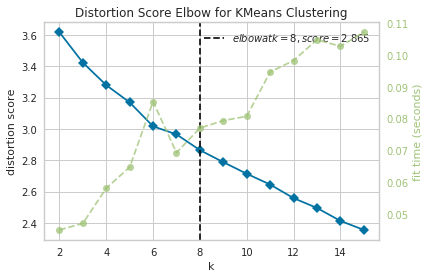

In [34]:
#we prepare our Xdata

t_grouped_clustering = t_grouped.drop('Neighborhood', 1)


model = KElbowVisualizer(KMeans(), k=15)
model.fit(t_grouped_clustering)
model.show()


Now that we get our best K=10, we create our Kmeans model

In [35]:
kclusters=10
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(t_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50]

array([5, 8, 7, 2, 2, 2, 3, 7, 7, 2, 7, 8, 2, 1, 8, 2, 7, 6, 6, 6, 0, 1,
       7, 2, 7, 2, 2, 1, 3, 2, 3, 7, 6, 7, 7, 5, 6, 2, 8, 7, 6, 6, 7, 1,
       3, 7, 3, 8, 1, 7], dtype=int32)

Now let's create the new dataframe and display the top 10 venues for each neighborhood and a function to sort the venues in descending order.

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = t_grouped['Neighborhood']

for ind in np.arange(t_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(t_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.shape

(127, 11)


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [53]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'].astype('int32')

t_merged = df_geo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
t_merged = t_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#t_merged=pd.merge(t_merged, neighborhoods_venues_sorted, on='Neighborhood',how='outer')
t_merged.dropna(axis=0,inplace=True)# check the fillna(last columns!
t_merged.head()

,Borough,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CARABANCHEL,ABRANTES,-3.7282,40.3808,5,Metro Station,Bar,Fast Food Restaurant,Bus Station,Plaza,Supermarket,Tapas Restaurant,Kebab Restaurant,Athletics & Sports,Soccer Field
1,ARGANZUELA,ACACIAS,-3.7062,40.4019,8,Tapas Restaurant,Coffee Shop,Bar,Plaza,Park,Art Gallery,Gym / Fitness Center,Spanish Restaurant,Pizza Place,Café
2,RETIRO,ADELFAS,-3.6711,40.4011,7,Spanish Restaurant,Market,Food & Drink Shop,Pub,Bar,Restaurant,Peruvian Restaurant,Indian Restaurant,Tapas Restaurant,Hotel
3,BARAJAS,AEROPUERTO,-3.5706,40.4548,2,Duty-free Shop,Spanish Restaurant,Accessories Store,Rental Car Location,Restaurant,Auto Garage,Diner,Coffee Shop,Paella Restaurant,Road
4,BARAJAS,ALAMEDA DE OSUNA,-3.5901,40.4569,2,Spanish Restaurant,Hotel,Park,Restaurant,Chinese Restaurant,Hotel Bar,Bar,Breakfast Spot,Garden,Tapas Restaurant


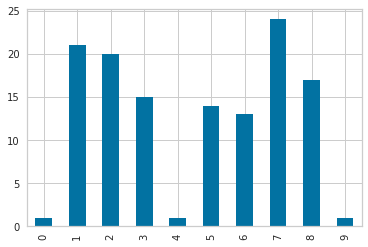

In [54]:
t_merged['Cluster Labels'].value_counts().sort_index(ascending=True).plot(kind='bar')


Finally, let's visualize the cluster to identify and make a proper label for each one.

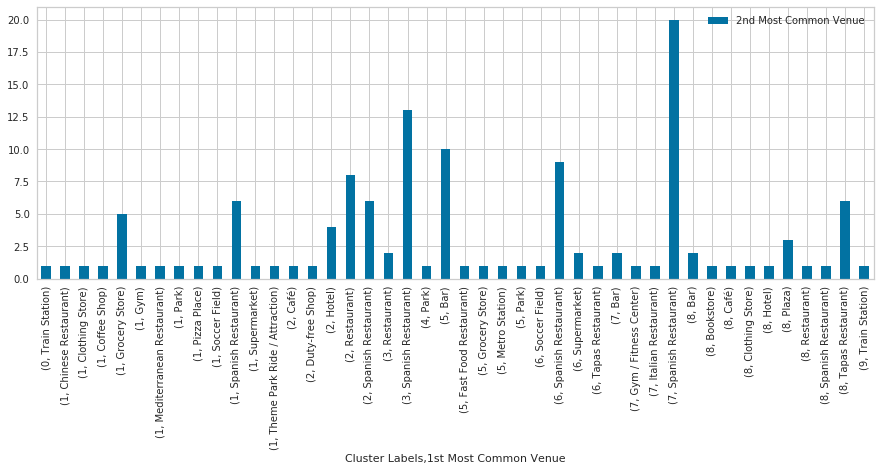

In [55]:
t_clustercount=t_merged[['Cluster Labels','1st Most Common Venue','2nd Most Common Venue']].groupby(['Cluster Labels','1st Most Common Venue']).count().plot(kind='bar',figsize=(15,5))
t_clustercount

I create a special column to concatenate the information of the 3 first Venue to put in the map.

In [56]:
t_merged['Label data']='1 '+ t_merged['1st Most Common Venue']+' 2 '+t_merged['2nd Most Common Venue']+' 3 '+t_merged['3rd Most Common Venue']
t_merged.head()

,Borough,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data
0,CARABANCHEL,ABRANTES,-3.7282,40.3808,5,Metro Station,Bar,Fast Food Restaurant,Bus Station,Plaza,Supermarket,Tapas Restaurant,Kebab Restaurant,Athletics & Sports,Soccer Field,1 Metro Station 2 Bar 3 Fast Food Restaurant
1,ARGANZUELA,ACACIAS,-3.7062,40.4019,8,Tapas Restaurant,Coffee Shop,Bar,Plaza,Park,Art Gallery,Gym / Fitness Center,Spanish Restaurant,Pizza Place,Café,1 Tapas Restaurant 2 Coffee Shop 3 Bar
2,RETIRO,ADELFAS,-3.6711,40.4011,7,Spanish Restaurant,Market,Food & Drink Shop,Pub,Bar,Restaurant,Peruvian Restaurant,Indian Restaurant,Tapas Restaurant,Hotel,1 Spanish Restaurant 2 Market 3 Food & Drink Shop
3,BARAJAS,AEROPUERTO,-3.5706,40.4548,2,Duty-free Shop,Spanish Restaurant,Accessories Store,Rental Car Location,Restaurant,Auto Garage,Diner,Coffee Shop,Paella Restaurant,Road,1 Duty-free Shop 2 Spanish Restaurant 3 Access...
4,BARAJAS,ALAMEDA DE OSUNA,-3.5901,40.4569,2,Spanish Restaurant,Hotel,Park,Restaurant,Chinese Restaurant,Hotel Bar,Bar,Breakfast Spot,Garden,Tapas Restaurant,1 Spanish Restaurant 2 Hotel 3 Park


Let's do a histogram to analize the average income to put in different groups.

,Borough code,Neighborhood,Average income,Neighborhood Title New
122,28079BAR127,PRADOLONGO,23.174,Pradolongo
123,28079BAR131,ENTREVIAS,22.055,Entrevias
124,28079BAR203,AMPOSTA,21.842,Amposta
125,28079BAR132,SAN DIEGO,21.225,San Diego
126,28079BAR172,SAN CRISTOBAL,19.587,San Cristobal


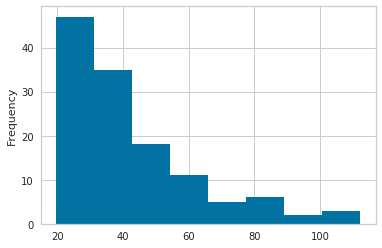

In [57]:
df_income['Average income'].plot(kind='hist',bins=8)
df_income.tail().sort_values(['Average income'],ascending=False)

Let's join the data of cluster and the venues

In [58]:
df_ma=df_income[['Neighborhood','Average income','Neighborhood Title New']]
t_merged=pd.merge(t_merged,df_ma , on='Neighborhood')
t_merged.head()


,Borough,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data,Average income,Neighborhood Title New
0,CARABANCHEL,ABRANTES,-3.7282,40.3808,5,Metro Station,Bar,Fast Food Restaurant,Bus Station,Plaza,Supermarket,Tapas Restaurant,Kebab Restaurant,Athletics & Sports,Soccer Field,1 Metro Station 2 Bar 3 Fast Food Restaurant,27.998,Abrantes
1,ARGANZUELA,ACACIAS,-3.7062,40.4019,8,Tapas Restaurant,Coffee Shop,Bar,Plaza,Park,Art Gallery,Gym / Fitness Center,Spanish Restaurant,Pizza Place,Café,1 Tapas Restaurant 2 Coffee Shop 3 Bar,44.669,Acacias
2,RETIRO,ADELFAS,-3.6711,40.4011,7,Spanish Restaurant,Market,Food & Drink Shop,Pub,Bar,Restaurant,Peruvian Restaurant,Indian Restaurant,Tapas Restaurant,Hotel,1 Spanish Restaurant 2 Market 3 Food & Drink Shop,45.843,Adelfas
3,BARAJAS,AEROPUERTO,-3.5706,40.4548,2,Duty-free Shop,Spanish Restaurant,Accessories Store,Rental Car Location,Restaurant,Auto Garage,Diner,Coffee Shop,Paella Restaurant,Road,1 Duty-free Shop 2 Spanish Restaurant 3 Access...,24.254,Aeropuerto
4,BARAJAS,ALAMEDA DE OSUNA,-3.5901,40.4569,2,Spanish Restaurant,Hotel,Park,Restaurant,Chinese Restaurant,Hotel Bar,Bar,Breakfast Spot,Garden,Tapas Restaurant,1 Spanish Restaurant 2 Hotel 3 Park,52.281,Alameda De Osuna


Let's rename the cluster with an evaluation of each cluster common Venue,

In [78]:
conditions={0:'Transport area',
           1:'Commercial Area',
           2:'Accomodation & Food Venues',
           3:'Spanish Restaurant',
           4:'Green Area',
           5:'Bar Area',
           6:'Gastronomic and Market Area',
           7:'Spanish Restaurant',
           8:'Tourist Area',
           9:'Transport area'}
t_merged['New Cluster Labels']=t_merged['Cluster Labels'].map(conditions)
t_merged.head()

,Borough,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data,Average income,Neighborhood Title New,New Cluster Labels,Income group
0,CARABANCHEL,ABRANTES,-3.7282,40.3808,5,Metro Station,Bar,Fast Food Restaurant,Bus Station,Plaza,Supermarket,Tapas Restaurant,Kebab Restaurant,Athletics & Sports,Soccer Field,1 Metro Station 2 Bar 3 Fast Food Restaurant,27.998,Abrantes,Bar Area,Low Average Income
1,ARGANZUELA,ACACIAS,-3.7062,40.4019,8,Tapas Restaurant,Coffee Shop,Bar,Plaza,Park,Art Gallery,Gym / Fitness Center,Spanish Restaurant,Pizza Place,Café,1 Tapas Restaurant 2 Coffee Shop 3 Bar,44.669,Acacias,Tourist Area,Middle_low Average Income
2,RETIRO,ADELFAS,-3.6711,40.4011,7,Spanish Restaurant,Market,Food & Drink Shop,Pub,Bar,Restaurant,Peruvian Restaurant,Indian Restaurant,Tapas Restaurant,Hotel,1 Spanish Restaurant 2 Market 3 Food & Drink Shop,45.843,Adelfas,Spanish Restaurant,Middle_low Average Income
3,BARAJAS,AEROPUERTO,-3.5706,40.4548,2,Duty-free Shop,Spanish Restaurant,Accessories Store,Rental Car Location,Restaurant,Auto Garage,Diner,Coffee Shop,Paella Restaurant,Road,1 Duty-free Shop 2 Spanish Restaurant 3 Access...,24.254,Aeropuerto,Accomodation & Food Venues,Low Average Income
4,BARAJAS,ALAMEDA DE OSUNA,-3.5901,40.4569,2,Spanish Restaurant,Hotel,Park,Restaurant,Chinese Restaurant,Hotel Bar,Bar,Breakfast Spot,Garden,Tapas Restaurant,1 Spanish Restaurant 2 Hotel 3 Park,52.281,Alameda De Osuna,Accomodation & Food Venues,Middle Average Income


In [60]:
t_merged['Income group'] = np.where(t_merged['Average income'].between(19.000, 30.000, inclusive=False), 'Low Average Income',     
     np.where(t_merged['Average income'].between(30.001, 41.000, inclusive=False), 'Low-high Average Income', 
         np.where(t_merged['Average income'].between(41.001, 52.000, inclusive=False), 'Middle_low Average Income',
                  np.where(t_merged['Average income'].between(52.001, 63.000, inclusive=False), 'Middle Average Income',
                           np.where(t_merged['Average income'].between(63.001, 74.000, inclusive=False), 'Middle-high Average Income',
                                    np.where(t_merged['Average income'].between(74.001, 85.000, inclusive=False), 'High-Low Average Income',
                                             np.where(t_merged['Average income'].between(85.001, 96.000, inclusive=False), 'High Average Income',
                                                      np.where(t_merged['Average income'].between(96.001, 15.0000, inclusive=False), 'High-High Average Income','Unknown'
     )))))))
)

In [61]:
t_merged.head()

,Borough,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data,Average income,Neighborhood Title New,New Cluster Labels,Income group
0,CARABANCHEL,ABRANTES,-3.7282,40.3808,5,Metro Station,Bar,Fast Food Restaurant,Bus Station,Plaza,Supermarket,Tapas Restaurant,Kebab Restaurant,Athletics & Sports,Soccer Field,1 Metro Station 2 Bar 3 Fast Food Restaurant,27.998,Abrantes,Business Area,Low Average Income
1,ARGANZUELA,ACACIAS,-3.7062,40.4019,8,Tapas Restaurant,Coffee Shop,Bar,Plaza,Park,Art Gallery,Gym / Fitness Center,Spanish Restaurant,Pizza Place,Café,1 Tapas Restaurant 2 Coffee Shop 3 Bar,44.669,Acacias,Spanish Restaurant,Middle_low Average Income
2,RETIRO,ADELFAS,-3.6711,40.4011,7,Spanish Restaurant,Market,Food & Drink Shop,Pub,Bar,Restaurant,Peruvian Restaurant,Indian Restaurant,Tapas Restaurant,Hotel,1 Spanish Restaurant 2 Market 3 Food & Drink Shop,45.843,Adelfas,Entertainment Area,Middle_low Average Income
3,BARAJAS,AEROPUERTO,-3.5706,40.4548,2,Duty-free Shop,Spanish Restaurant,Accessories Store,Rental Car Location,Restaurant,Auto Garage,Diner,Coffee Shop,Paella Restaurant,Road,1 Duty-free Shop 2 Spanish Restaurant 3 Access...,24.254,Aeropuerto,Multiple Social Venues,Low Average Income
4,BARAJAS,ALAMEDA DE OSUNA,-3.5901,40.4569,2,Spanish Restaurant,Hotel,Park,Restaurant,Chinese Restaurant,Hotel Bar,Bar,Breakfast Spot,Garden,Tapas Restaurant,1 Spanish Restaurant 2 Hotel 3 Park,52.281,Alameda De Osuna,Multiple Social Venues,Middle Average Income


It is needed to Title the Column Neighborhood to mathc with the json data

In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,data,tips, income in zip(t_merged['Latitude'].astype(float), t_merged['Longitude'].astype(float), t_merged['Neighborhood'], t_merged['Cluster Labels'].astype(int),t_merged['New Cluster Labels'],t_merged['Label data'], t_merged['Income group']):
    label = folium.Popup(str(poi) + ' / ' + str(data) + ' / '+ str(income) + ' / ' +str(tips), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=1).add_to(map_clusters)
        
    


map_clusters

In [63]:
t_merged.loc[t_merged['Cluster Labels'] == 0,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data,Average income,Neighborhood Title New,New Cluster Labels,Income group
20,BUTARQUE,Train Station,Sports Bar,Plaza,Café,Sandwich Place,Athletics & Sports,Grocery Store,Latin American Restaurant,Dumpling Restaurant,Duty-free Shop,1 Train Station 2 Sports Bar 3 Plaza,30.153,Butarque,Spanish Restaurant,Low-high Average Income


In [64]:
t_merged.loc[t_merged['Cluster Labels'] == 1,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data,Average income,Neighborhood Title New,New Cluster Labels,Income group
13,ARCOS,Chinese Restaurant,Grocery Store,Supermarket,Pizza Place,Spanish Restaurant,Burger Joint,Steakhouse,Food,Soccer Field,Snack Place,1 Chinese Restaurant 2 Grocery Store 3 Superma...,28.111,Arcos,Gastronomic Area,Low Average Income
21,CAMPAMENTO,Grocery Store,Bar,Coffee Shop,Bus Station,Metro Station,Diner,Supermarket,Light Rail Station,Department Store,Clothing Store,1 Grocery Store 2 Bar 3 Coffee Shop,31.913,Campamento,Gastronomic Area,Low-high Average Income
27,CASCO HISTORICO DE VICALVARO,Spanish Restaurant,Pizza Place,Park,Grocery Store,Fast Food Restaurant,Market,Metro Station,Photography Studio,Breakfast Spot,Flea Market,1 Spanish Restaurant 2 Pizza Place 3 Park,34.498,Casco Historico De Vicalvaro,Gastronomic Area,Low-high Average Income
43,EL GOLOSO,Grocery Store,Restaurant,Italian Restaurant,Pharmacy,Burger Joint,Deli / Bodega,Asian Restaurant,Pizza Place,Bar,Supermarket,1 Grocery Store 2 Restaurant 3 Italian Restaurant,57.441,El Goloso,Gastronomic Area,Middle Average Income
48,ENTREVIAS,Spanish Restaurant,Pizza Place,Clothing Store,Park,Toy / Game Store,College & University,Restaurant,Music Venue,Burger Joint,Shopping Mall,1 Spanish Restaurant 2 Pizza Place 3 Clothing ...,22.055,Entrevias,Gastronomic Area,Low Average Income
52,FUENTELARREINA,Grocery Store,Park,Bakery,Hotel,Pizza Place,Deli / Bodega,Department Store,Restaurant,Spanish Restaurant,Golf Course,1 Grocery Store 2 Park 3 Bakery,98.156,Fuentelarreina,Gastronomic Area,Unknown
58,HORCAJO,Spanish Restaurant,Tapas Restaurant,Gym / Fitness Center,Park,Grocery Store,Metro Station,Pizza Place,Breakfast Spot,Pharmacy,Athletics & Sports,1 Spanish Restaurant 2 Tapas Restaurant 3 Gym ...,45.041,Horcajo,Gastronomic Area,Middle_low Average Income
67,LOS ANGELES,Spanish Restaurant,Café,Grocery Store,Pet Store,Park,Metro Station,Bar,Gastropub,Electronics Store,Bus Station,1 Spanish Restaurant 2 Café 3 Grocery Store,28.062,Los Angeles,Gastronomic Area,Low Average Income
68,LOS CARMENES,Grocery Store,Pizza Place,Bakery,Supermarket,Asian Restaurant,Fast Food Restaurant,Sandwich Place,Lake,Café,Bar,1 Grocery Store 2 Pizza Place 3 Bakery,29.541,Los Carmenes,Gastronomic Area,Low Average Income
69,LOS ROSALES,Spanish Restaurant,Pizza Place,Pet Store,Metro Station,Park,Soccer Field,Bus Station,Electronics Store,Supermarket,Café,1 Spanish Restaurant 2 Pizza Place 3 Pet Store,28.416,Los Rosales,Gastronomic Area,Low Average Income


In [65]:
t_merged.loc[t_merged['Cluster Labels'] == 2,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data,Average income,Neighborhood Title New,New Cluster Labels,Income group
3,AEROPUERTO,Duty-free Shop,Spanish Restaurant,Accessories Store,Rental Car Location,Restaurant,Auto Garage,Diner,Coffee Shop,Paella Restaurant,Road,1 Duty-free Shop 2 Spanish Restaurant 3 Access...,24.254,Aeropuerto,Multiple Social Venues,Low Average Income
4,ALAMEDA DE OSUNA,Spanish Restaurant,Hotel,Park,Restaurant,Chinese Restaurant,Hotel Bar,Bar,Breakfast Spot,Garden,Tapas Restaurant,1 Spanish Restaurant 2 Hotel 3 Park,52.281,Alameda De Osuna,Multiple Social Venues,Middle Average Income
5,ALMAGRO,Restaurant,Spanish Restaurant,Hotel,Tapas Restaurant,Japanese Restaurant,Italian Restaurant,Asian Restaurant,Boutique,Plaza,Bar,1 Restaurant 2 Spanish Restaurant 3 Hotel,68.787,Almagro,Multiple Social Venues,Middle-high Average Income
9,AMPOSTA,Spanish Restaurant,Restaurant,Supermarket,Chinese Restaurant,Asian Restaurant,Café,Steakhouse,Soccer Field,Snack Place,Burger Joint,1 Spanish Restaurant 2 Restaurant 3 Supermarket,21.842,Amposta,Multiple Social Venues,Low Average Income
12,ARAVACA,Restaurant,Café,Breakfast Spot,Deli / Bodega,Brewery,Athletics & Sports,Falafel Restaurant,Diner,Supermarket,Italian Restaurant,1 Restaurant 2 Café 3 Breakfast Spot,77.061,Aravaca,Multiple Social Venues,High-Low Average Income
15,ATALAYA,Restaurant,Spanish Restaurant,Hotel,Plaza,Chinese Restaurant,Asian Restaurant,Bakery,Park,Fast Food Restaurant,Bar,1 Restaurant 2 Spanish Restaurant 3 Hotel,67.826,Atalaya,Multiple Social Venues,Middle-high Average Income
23,CANILLEJAS,Spanish Restaurant,Hotel,Pizza Place,Restaurant,Rock Club,Tennis Court,Grocery Store,Gastropub,Park,Pet Store,1 Spanish Restaurant 2 Hotel 3 Pizza Place,31.306,Canillejas,Multiple Social Venues,Low-high Average Income
25,CASCO HISTORICO DE BARAJAS,Hotel,Spanish Restaurant,Restaurant,Airport Service,Coffee Shop,Duty-free Shop,Airport Lounge,Airport Terminal,Tapas Restaurant,Argentinian Restaurant,1 Hotel 2 Spanish Restaurant 3 Restaurant,29.450,Casco Historico De Barajas,Multiple Social Venues,Low Average Income
26,CASCO HISTORICO DE VALLECAS,Restaurant,Park,Grocery Store,Bakery,Hotel,Auto Garage,Pie Shop,Cupcake Shop,Church,Chinese Restaurant,1 Restaurant 2 Park 3 Grocery Store,28.357,Casco Historico De Vallecas,Multiple Social Venues,Low Average Income
29,CASTILLA,Hotel,Spanish Restaurant,Restaurant,Sandwich Place,Italian Restaurant,Coffee Shop,Bar,Fast Food Restaurant,Mediterranean Restaurant,Plaza,1 Hotel 2 Spanish Restaurant 3 Restaurant,54.870,Castilla,Multiple Social Venues,Middle Average Income


In [66]:
t_merged.loc[t_merged['Cluster Labels'] == 3,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data,Average income,Neighborhood Title New,New Cluster Labels,Income group
6,ALMENARA,Spanish Restaurant,Restaurant,Hotel,Italian Restaurant,Chinese Restaurant,Coffee Shop,Mediterranean Restaurant,Seafood Restaurant,Sandwich Place,Asian Restaurant,1 Spanish Restaurant 2 Restaurant 3 Hotel,28.747,Almenara,Spanish Restaurant,Low Average Income
28,CASTELLANA,Spanish Restaurant,Restaurant,Tapas Restaurant,Hotel,Mediterranean Restaurant,Boutique,Coffee Shop,Japanese Restaurant,Jewelry Store,Clothing Store,1 Spanish Restaurant 2 Restaurant 3 Tapas Rest...,82.811,Castellana,Spanish Restaurant,High-Low Average Income
30,CASTILLEJOS,Spanish Restaurant,Restaurant,Hotel,Japanese Restaurant,Chinese Restaurant,Burger Joint,Steakhouse,Brewery,Seafood Restaurant,Pub,1 Spanish Restaurant 2 Restaurant 3 Hotel,45.025,Castillejos,Spanish Restaurant,Middle_low Average Income
44,EL PARDO,Spanish Restaurant,Restaurant,Plaza,Government Building,Tapas Restaurant,Bakery,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,1 Spanish Restaurant 2 Restaurant 3 Plaza,39.062,El Pardo,Spanish Restaurant,Low-high Average Income
46,EL VISO,Spanish Restaurant,Restaurant,Coffee Shop,Pizza Place,Soccer Stadium,Mediterranean Restaurant,Café,Tapas Restaurant,Japanese Restaurant,Burger Joint,1 Spanish Restaurant 2 Restaurant 3 Coffee Shop,103.573,El Viso,Spanish Restaurant,Unknown
51,FUENTE DEL BERRO,Spanish Restaurant,Seafood Restaurant,Restaurant,Bakery,Plaza,Coffee Shop,Italian Restaurant,Bar,Supermarket,Park,1 Spanish Restaurant 2 Seafood Restaurant 3 Re...,40.504,Fuente Del Berro,Spanish Restaurant,Low-high Average Income
54,GOYA,Spanish Restaurant,Restaurant,Tapas Restaurant,Coffee Shop,Seafood Restaurant,Bakery,Burger Joint,Furniture / Home Store,Plaza,Supermarket,1 Spanish Restaurant 2 Restaurant 3 Tapas Rest...,48.815,Goya,Spanish Restaurant,Middle_low Average Income
55,GUINDALERA,Spanish Restaurant,Seafood Restaurant,Restaurant,Hotel,Tapas Restaurant,Bar,Bakery,Indian Restaurant,Supermarket,Café,1 Spanish Restaurant 2 Seafood Restaurant 3 Re...,46.341,Guindalera,Spanish Restaurant,Middle_low Average Income
57,HISPANOAMERICA,Spanish Restaurant,Restaurant,Tapas Restaurant,Coffee Shop,Bakery,Pizza Place,Plaza,Supermarket,Seafood Restaurant,Café,1 Spanish Restaurant 2 Restaurant 3 Tapas Rest...,62.635,Hispanoamerica,Spanish Restaurant,Middle Average Income
59,IBIZA,Spanish Restaurant,Restaurant,Tapas Restaurant,Bakery,Ice Cream Shop,Seafood Restaurant,Italian Restaurant,Mediterranean Restaurant,Burger Joint,Dessert Shop,1 Spanish Restaurant 2 Restaurant 3 Tapas Rest...,45.561,Ibiza,Spanish Restaurant,Middle_low Average Income


In [67]:
t_merged.loc[t_merged['Cluster Labels'] == 4,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data,Average income,Neighborhood Title New,New Cluster Labels,Income group
79,ORCASITAS,Park,Spanish Restaurant,Sporting Goods Shop,Athletics & Sports,Beer Garden,Fast Food Restaurant,Farmers Market,Grocery Store,Train Station,Exhibit,1 Park 2 Spanish Restaurant 3 Sporting Goods Shop,26.858,Orcasitas,Green Area,Low Average Income


In [77]:
t_merged.loc[t_merged['Cluster Labels'] == 5,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Label data,Average income,Neighborhood Title New,New Cluster Labels,Income group
0,ABRANTES,Metro Station,Bar,Fast Food Restaurant,Bus Station,Plaza,Supermarket,Tapas Restaurant,Kebab Restaurant,Athletics & Sports,Soccer Field,1 Metro Station 2 Bar 3 Fast Food Restaurant,27.998,Abrantes,Business Area,Low Average Income
35,COMILLAS,Park,Spanish Restaurant,Bar,Playground,Pizza Place,Tapas Restaurant,Coffee Shop,Plaza,Fast Food Restaurant,Grocery Store,1 Park 2 Spanish Restaurant 3 Bar,27.579,Comillas,Business Area,Low Average Income
50,FONTARRON,Bar,Café,Park,Plaza,Metro Station,Brewery,Beer Garden,Tapas Restaurant,Sushi Restaurant,Supermarket,1 Bar 2 Café 3 Park,28.014,Fontarron,Business Area,Low Average Income
64,LAS AGUILAS,Bar,Spanish Restaurant,Supermarket,Tapas Restaurant,Burger Joint,Pizza Place,Train Station,Clothing Store,Market,Kebab Restaurant,1 Bar 2 Spanish Restaurant 3 Supermarket,29.910,Las Aguilas,Business Area,Low Average Income
71,MARROQUINA,Bar,Plaza,Restaurant,Pizza Place,Park,Bakery,Brewery,Athletics & Sports,Sushi Restaurant,Supermarket,1 Bar 2 Plaza 3 Restaurant,40.428,Marroquina,Business Area,Low-high Average Income
72,MEDIA LEGUA,Bar,Coffee Shop,Supermarket,Fast Food Restaurant,Pub,Plaza,Pool,Restaurant,Pizza Place,Chinese Restaurant,1 Bar 2 Coffee Shop 3 Supermarket,35.439,Media Legua,Business Area,Low-high Average Income
78,OPANEL,Bar,Gym / Fitness Center,Plaza,Bakery,Concert Hall,Pizza Place,Tapas Restaurant,Supermarket,Café,Kebab Restaurant,1 Bar 2 Gym / Fitness Center 3 Plaza,28.031,Opanel,Business Area,Low Average Income
85,PALOMERAS SURESTE,Bar,Grocery Store,Breakfast Spot,Asian Restaurant,Pool,Deli / Bodega,Restaurant,Café,Seafood Restaurant,Fast Food Restaurant,1 Bar 2 Grocery Store 3 Breakfast Spot,26.632,Palomeras Sureste,Business Area,Low Average Income
92,PORTAZGO,Bar,Grocery Store,Fast Food Restaurant,Tapas Restaurant,Restaurant,Metro Station,Spanish Restaurant,Motorcycle Shop,Coffee Shop,Electronics Store,1 Bar 2 Grocery Store 3 Fast Food Restaurant,23.825,Portazgo,Business Area,Low Average Income
107,SAN ISIDRO,Grocery Store,Plaza,Park,Fast Food Restaurant,Supermarket,Bar,Concert Hall,Gym / Fitness Center,Kebab Restaurant,Coffee Shop,1 Grocery Store 2 Plaza 3 Park,26.283,San Isidro,Business Area,Low Average Income


In [74]:
table = pd.pivot_table(t_merged,values='Latitude', columns='Cluster Labels', index='1st Most Common Venue',fill_value='0',aggfunc='count')
table

Cluster Labels,0,1,2,3,4,5,6,7,8,9
1st Most Common Venue,,,,,,,,,,
Bar,0,0,0,0,0,10,0,2,2,0
Bookstore,0,0,0,0,0,0,0,0,1,0
Café,0,0,1,0,0,0,0,0,1,0
Chinese Restaurant,0,1,0,0,0,0,0,0,0,0
Clothing Store,0,1,0,0,0,0,0,0,1,0
Coffee Shop,0,1,0,0,0,0,0,0,0,0
Duty-free Shop,0,0,1,0,0,0,0,0,0,0
Fast Food Restaurant,0,0,0,0,0,1,0,0,0,0
Grocery Store,0,5,0,0,0,1,0,0,0,0
